<a href="https://colab.research.google.com/github/DT6A/Hands-On_Machine_Learning/blob/main/ML15_Reinforcment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym

In [ ]:
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [ ]:
import gym

env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([ 0.04135124,  0.0060921 ,  0.01867532, -0.03879297])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
img = env.render(mode='rgb_array')

In [ ]:
env.action_space

Discrete(2)

In [ ]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.03479639,  0.15159143,  0.03726383, -0.3187035 ])

In [ ]:
reward

1.0

In [ ]:
done

False

In [ ]:
info

{}

In [ ]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(1000): # max 1000 steps
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [ ]:
import numpy as np

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.928, 8.381575985457626, 24.0, 71.0)

## Neural Network Policies

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

# 1. Specify the NN architecture
n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4 # No need for more
n_outputs = 1 # Probability of accelerating left
initializer = tf.initializers.he_normal()

# 2. Build the NN
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                        kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                        kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

# 3. Select a random action based on probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)

learning_rate = 0.01

xentr = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(xentr)

gradients = [grad for grad, variable in grads_and_vars]

gradient_placeholders = []
grads_and_vars_feed = []

for grad, variable in grads_and_vars:
  gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
  gradient_placeholders.append(gradient_placeholder)
  grads_and_vars_feed.append((gradient_placeholder, variable))

  
training_op = optimizer.apply_gradients(grads_and_vars_feed)


init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
def discount_rewards(rewards, gamma):
  discounted_rewards = np.empty(len(rewards))
  cumulative_rewards = 0
  for step in reversed(range(len(rewards))):
    cumulative_rewards = rewards[step] + cumulative_rewards * gamma
    discounted_rewards[step] = cumulative_rewards
  return discounted_rewards

def discount_and_normalize(all_rewards, gamma):
  all_discounted_rewards = [discount_rewards(rewards, gamma)
                           for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discounted_rewards - reward_mean)/reward_std
         for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_rewards([10, 0, -50], gamma=0.8)

array([-22., -40., -50.])

In [ ]:
discount_and_normalize([[10, 0, -50], [10, 20]], gamma=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
n_iterations = 250      # number of training iterations
n_max_steps = 1000      # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 10    # save the model every 10 trainig iterations
gamma = 0.95            # the discount factor

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    print(iteration)
    all_rewards = []   # all sequnces of rewards for each episode
    all_gradients = [] # gradients saved at each step of each episode
    for game in range(n_games_per_update):
      current_rewards = []   # all raw rewards from the current episode
      current_gradients = [] # all gradients from the current episode
      obs = env.reset()
      for step in range(n_max_steps):
        action_val, gradients_val = sess.run(
                         [action, gradients],
                         feed_dict={X: obs.reshape(1, n_inputs)}) # one obs
        obs, reward, done, info = env.step(action_val[0][0])
        current_rewards.append(reward)
        current_gradients.append(gradients_val)
        if done:
          break
      all_rewards.append(current_rewards)
      all_gradients.append(current_gradients)
      
    # Updating policy
    all_rewards = discount_and_normalize(all_rewards, gamma)
    feed_dict = {}
    for var_index, grad_placeholder in enumerate(gradient_placeholders):
      # multiply the gradients by the action scores, and compute the mean
      mean_gradients = np.mean(
                [reward * all_gradients[game_index][step][var_index]
                for game_index, rewards in enumerate(all_rewards)
                for step, reward in enumerate(rewards)], 
          axis=0)
      feed_dict[grad_placeholder] = mean_gradients
    sess.run(training_op, feed_dict=feed_dict)
    if iteration % save_iterations == 0:
      save_path = saver.save(sess, './my_policy_net_pg.ckpt')

In [ ]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [ ]:
frames = []

obs = env.reset()
for i in range(100):
  frames.append(render_cart_pole(env, obs))
  obs, reward, done, info = env.step(1)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
video = plot_animation(frames)

<IPython.core.display.Javascript object>

In [ ]:
video

In [ ]:
video.to_jshtml()

'\n<link rel="stylesheet"\nhref="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/\ncss/font-awesome.min.css">\n<script language="javascript">\n  /* Define the Animation class */\n  function Animation(frames, img_id, slider_id, interval, loop_select_id){\n    this.img_id = img_id;\n    this.slider_id = slider_id;\n    this.loop_select_id = loop_select_id;\n    this.interval = interval;\n    this.current_frame = 0;\n    this.direction = 0;\n    this.timer = null;\n    this.frames = new Array(frames.length);\n\n    for (var i=0; i<frames.length; i++)\n    {\n     this.frames[i] = new Image();\n     this.frames[i].src = frames[i];\n    }\n    document.getElementById(this.slider_id).max = this.frames.length - 1;\n    this.set_frame(this.current_frame);\n  }\n\n  Animation.prototype.get_loop_state = function(){\n    var button_group = document[this.loop_select_id].state;\n    for (var i = 0; i < button_group.length; i++) {\n        var button = button_group[i];\n        if (button.checked

In [ ]:
frames = []

with tf.Session() as sess:
  saver.restore(sess, save_path)
  
  totals = []
  for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    frames.append(render_cart_pole(env, obs))
    for step in range(1000): # max 1000 steps
      act = sess.run(action, feed_dict={X: obs.reshape(-1, 4)})
      obs, reward, done, info = env.step(act[0][0])
      frames.append(render_cart_pole(env, obs))
      episode_rewards += reward
      if done:
        break
    totals.append(episode_rewards)

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(195.974, 14.14288952088646, 110.0, 200.0)

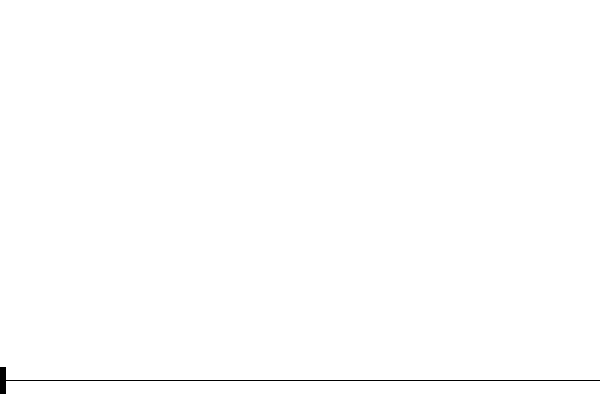

In [ ]:
import IPython
import time 

def draw_frames(frames):
  for f in frames:
    IPython.display.clear_output(wait=True)
    time.sleep(0.3)
    IPython.display.display_png(Image.fromarray(f))
draw_frames(frames)

In [ ]:
import imageio 

def create_gif(frames, name):
  with imageio.get_writer(name, mode='I') as writer: 
    for f in frames: 
      writer.append_data(f)

##Markov Decision Processes

In [ ]:
nan = np.nan # represents impossible actions
T = np.array([ # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
    [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],    
])
R = np.array([ # shape=[s, a, s']
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.0]],
    [[nan, nan, nan], [40., 0.0,0.0], [nan, nan, nan]],    
])
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
Q = np.full((3, 3), -np.inf) # -inf for impossible actions
for state, action in enumerate(possible_actions):
  Q[state, action] = 0.0
  
gamma = 0.95 # the discount factor
n_iterations = 100

for iteration in range(n_iterations):
  Q_prev = Q.copy()
  for s in range(3):
    for a in possible_actions[s]:
      Q[s, a] = np.sum([
          T[s, a, sp] * (R[s, a, sp] + gamma * np.max(Q_prev[sp]))
          for sp in range(3)
      ])

In [ ]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

##Q-Learning

In [ ]:
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 50000

s = 0 # start in state 0

Q = np.full((3, 3), -np.inf) # -inf for impossible actions
for state, action in enumerate(possible_actions):
  Q[state, action] = 0.0 # initial value for all possible actions is 0

for iteration in range(n_iterations):
  a = np.random.choice(possible_actions[s])  # choose an action randomly
  sp = np.random.choice(range(3), p=T[s, a]) # pick the next state using T[s, a]
  reward = R[s, a, sp]
  learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
  Q[s, a] = ((1 - learning_rate) * Q[s, a] +
            learning_rate * (reward + gamma * np.max(Q[sp])))
  s = sp # move to the next state

NameError: ignored

In [ ]:
Q

## Ms. Pac-Man Using the DQN Algorithm

In [ ]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
#! pip3 install --upgrade 'gym[all]'

In [ ]:
env = gym.make('MsPacman-v0')
obs = env.reset()
obs.shape

(210, 160, 3)

In [ ]:
env.action_space

Discrete(9)

In [ ]:
mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
  img = obs[1:176:2, ::2] # crop and downsize
  img = img.mean(axis=2) # grayscale
  img[img==mspacman_color] = 0 # improve contrast
  img = (img - 128) / 128 - 1 # normalize from -1 to 1
  return img.reshape(88, 80, 1)

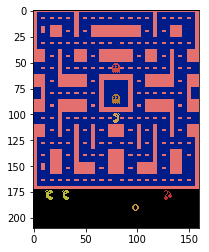

In [ ]:
%matplotlib inline

plt.imshow(obs)

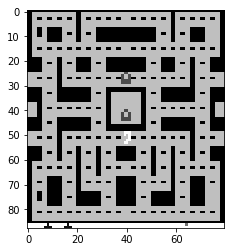

In [ ]:
plt.imshow(preprocess_observation(obs).reshape(88, 80), cmap='Greys')

In [ ]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8, 8), (4, 4), (3, 3)]
conv_strides = [4, 2, 1]
conv_paddings = ['SAME'] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.initializers.he_normal()

def q_network(X_state, name):
  prev_layer = X_state
  with tf.variable_scope(name) as scope:
    for n_maps, kernel_size, strides, padding, activation in zip(
        conv_n_maps, conv_kernel_sizes, conv_strides, 
        conv_paddings, conv_activation):
      prev_layer = tf.layers.conv2d(
          prev_layer, filters=n_maps, kernel_size=kernel_size,
          strides=strides, padding=padding, activation=activation,
          kernel_initializer=initializer)
    last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
    hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                             activation=hidden_activation,
                             kernel_initializer=initializer)
    outputs = tf.layers.dense(hidden, n_outputs,
                             kernel_initializer=initializer)
    
  trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                    scope=scope.name)
  trainable_vars_by_name = {var.name[len(scope.name):]: var
                           for var in trainable_vars}
  
  return outputs, trainable_vars_by_name

In [ ]:
tf.reset_default_graph()

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])

online_q_values, online_vars = q_network(X_state, name='q_networks/online')
target_q_values, target_vars = q_network(X_state, name='q_networks/target')

copy_ops = [target_var.assign(online_vars[var_name])
           for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

W0721 08:59:21.300699 140370031990656 deprecation.py:323] From <ipython-input-9-184b6f030142>:24: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0721 08:59:21.553649 140370031990656 deprecation.py:323] From <ipython-input-9-184b6f030142>:28: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [ ]:
X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(target_q_values * tf.one_hot(X_action, n_outputs),
                       axis=1, keepdims=True)

In [ ]:
y = tf.placeholder(tf.float32, shape=[None, 1])
error = tf.abs(y - q_value)
clipped_error = tf.clip_by_value(error, 0.0, 1.0)
linear_error = 2 * (error - clipped_error)
loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

In [ ]:
learning_rate = 0.001
momentum = 0.95

global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

W0721 08:59:22.094987 140370031990656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
from collections import deque

replay_memory_size = 175000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
  indices = np.random.permutation(len(replay_memory))[:batch_size]
  cols = [[], [], [], [], []] # state, action, reward, next_state, continue
  for idx in indices:
    memory = replay_memory[idx]
    for col, value in zip(cols, memory):
      col.append(value)
  cols = [np.array(col) for col in cols]
  return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3],
         cols[4].reshape(-1, 1))

In [ ]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
  epsilon = max(eps_min, eps_max - (eps_max - eps_min) * step / eps_decay_steps)
  if np.random.rand() < epsilon:
    return np.random.randint(n_outputs) # random action
  else:
    return np.argmax(q_values) # optimal action

In [ ]:
n_steps = 4000000
training_start = 10000 # start training after 10,000 game iterations
training_interval = 4 # run training operation every 4 game iterations
save_steps = 1000
copy_steps = 10000 # copy online DQN to target DQN every 10,000 steps
gamma = 0.99 # the discount factor
skip_start = 90 # Skip the start of every game(waiting time)
batch_size = 50
iteration = 0 # game iterations
checkpoint_path = './drive/My Drive/my_dqn2.ckpt'
done = True # env needs to be reset

In [ ]:
with tf.Session() as sess:
  if os.path.isfile(checkpoint_path + '.index'):
    saver.restore(sess, checkpoint_path)
  else:
    init.run()
    copy_online_to_target.run()
  while True:
    step = global_step.eval()
    
    if step != 0 and step % 10000 == 0:
      print(step, np.array(replay_memory)[:, 2].mean())
      
    if step >= n_steps:
      break
    iteration += 1
    if done: # game over, start again
      obs = env.reset()
      for skip in range(skip_start):
        obs, reward, done, info = env.step(0)
      state = preprocess_observation(obs)
      
    # Online DQN evaluates what to do
    q_values = online_q_values.eval(feed_dict={X_state: [state]})
    action = epsilon_greedy(q_values, step)
    
    # Online DQN plays
    obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(obs)
    
    # Memorize what just happend
    replay_memory.append((state, action, reward, next_state, 1.0 - done))
    state = next_state
    
    if iteration < training_start or iteration % training_interval != 0:
      continue # only train after warmup period and at regular intevals
      
    # Sample memories and use the target DQN to produce the target Q-Value
    X_state_val, X_action_val, rewards, X_next_state_val, continues = (
      sample_memories(batch_size))
    next_q_values = target_q_values.eval(
      feed_dict={X_state: X_next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + continues * gamma * max_next_q_values
    
    # Train the online DQN
    training_op.run(feed_dict={X_state: X_state_val,
                             X_action: X_action_val, y: y_val})
    
    # Regulary copy the online DQN to the target DQN
    if step % copy_steps == 0:
      copy_online_to_target.run()
      
    # Save regulary
    if step % save_steps == 0:
      saver.save(sess, checkpoint_path)

10000 0.44611428571428574
10000 0.44611428571428574
10000 0.44611428571428574
10000 0.44611428571428574
20000 0.43045714285714287
20000 0.43045714285714287
20000 0.43045714285714287
20000 0.43045714285714287
30000 0.4027428571428571
30000 0.4027428571428571
30000 0.4027428571428571
30000 0.4027428571428571


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


40000 0.37634285714285715
40000 0.37634285714285715
40000 0.37634285714285715
40000 0.37634285714285715
50000 0.37542857142857144
50000 0.37542857142857144
50000 0.37542857142857144
50000 0.37542857142857144
60000 0.36897142857142856
60000 0.36897142857142856
60000 0.36897142857142856
60000 0.36897142857142856
70000 0.3770857142857143
70000 0.3770857142857143
70000 0.3770857142857143
70000 0.3770857142857143
80000 0.38348571428571426
80000 0.38348571428571426
80000 0.38348571428571426
80000 0.38348571428571426
90000 0.38085714285714284
90000 0.38085714285714284
90000 0.38085714285714284
90000 0.38085714285714284
100000 0.3916
100000 0.3916
100000 0.3916
100000 0.3916
110000 0.38725714285714286
110000 0.38725714285714286
110000 0.38725714285714286
110000 0.38725714285714286
120000 0.39165714285714287
120000 0.39165714285714287
120000 0.39165714285714287
120000 0.39165714285714287
130000 0.3982857142857143
130000 0.3982857142857143
130000 0.3982857142857143
130000 0.3982857142857143
1400

In [ ]:
len(replay_memory)

176088

In [ ]:
np.array(replay_memory)[-100:, 2]

In [ ]:
frames = []
done = 0

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  obs = env.reset()
    
  st = 0
  while done == 0 and st < 2000:
    frames.append(obs)
    state = preprocess_observation(obs)
      
    # Online DQN evaluates what to do
    q_values = online_q_values.eval(feed_dict={X_state: [state]})
    action = epsilon_greedy(q_values, 2000000)
    
    obs, reward, done, info = env.step(action)
    
    st += 1

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
len(frames)

0

In [ ]:
create_gif(frames, 'ms_pac-man_v3.gif')

NameError: ignored